<a href="https://colab.research.google.com/github/SAIIL/CVS_challenge_code/blob/main/notebooks/cvs_challenge_sample_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<a href="https://cvs-challenge.grand-challenge.org/">
<img src="https://rumc-gcorg-p-public.s3.amazonaws.com/b/652/CVS_Challenge_Media_-_Summit_Ad_3.x20.jpeg" align="left"/>
</a>
</div>

## <h1><center>SAGES CVS Challenge Sample Code</center></h1>

In this notebook, we provide sample code to help you **familiarize yourself with the SAGES CVS challenge, visualize the dataset, and explore the metrics**. The notebook offers a minimal example of a simple deep learning pipeline to be applied on a small subset of the cvs challenge dataset before using the entire CVS challenge dataset.

The notebook contains step by step instructions to:

1.  Load & visualize the CVS Challenge data.
2.  Build & run a model for a multi-label classification task.
3.  Predict the three CVS criteria (C1, C2, and C3).
4.  Evaluate your model performance using the CVS challenge metrics.

**Important Notice:**
For more information on the SAGES CVS Challenge visit https://cvs-challenge.grand-challenge.org/ . Access to the SAGES CVS Challenge dataset is only provided to registered participants, who have signed the SAGES CVS Challenge Participation Agreement.


# Introduction


**Instructions for initial Demonstration:**
* For demonstration purposes of this notebook, we have added a zip file containing 3 sample videos of the CVS Challenge dataset.
* Run the notebook to verify you get a result file in the format of `results.json`.
* Run this colab with the provided zip file first, before attempting the entire CVS Challenge dataset on your machine.

**Data Structure**
* The provided zip file (`cvs_challenge_examples.zip`), here referred to as `data/`, contains subfoldes named:
* 'videos/' - containing 3 sample videos of the CVS Challenge dataset in the format `<video_filename>.mp4`
* 'labels/' - containing the annotations of the 3 sample videos of the CVS Challenge dataset in the format `<video_filename>/frame.csv`,`<video_filename>/video.csv`


**Instructions for actual CVS Challenge Competition:**
* When running on the full CVS challenge dataset, you will need to replace the `data/` folder in the colab with anew folder/location containing the entire CVS Challenge data (provided via Dropbox after successful registration).
* Additionally you need to mimic the format of `results.json` in your own classification pipeline.
* The data structure of the full CVS Challenge dataset remains the same as in the zip file (see above and README provided with full dataset).

# 1 - Data Loading and Visualization

In this section we demonstrate how to mount the colab and data, visualize the video frames and corresponding labels. For detailed instructions on the dataset and labels please visit https://cvs-challenge.grand-challenge.org/dataset/.

In [ ]:
!pip install -q timm

In [ ]:
# Mount a location on your GoogleDrive to store your colab and data.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the sample code from the CVSchallenge-repository (located on GitHub) to your colab.
!mkdir /root/.ssh

# Connect the mounted GoogleDrive link with the CVSchallenge-repository GitHub deploy key. Copy the GitHub key from
# https://drive.google.com/file/d/1xqUkSBlQ6h_kB-k2Pmo2qQMCB24xXCwx/view?usp=sharing, into your google drive, under cvs_colab_key, before running the colab.
!cp /content/drive/MyDrive/cvs_colab_key /root/.ssh/id_ed25519
!ssh-keyscan github.com >> /root/.ssh/known_hosts
# Using the GitHub key, download the CVS challenge code from the repository.
!rm -Rf CVS_challenge_code
!git clone git@github.com:SAIIL/CVS_challenge_code.git

# Add the GitHub code folder into the python path
import sys
sys.path.insert(0,'/content/CVS_challenge_code')

# Copy the data into the data directory
!mkdir ./data

# Important Notice: This currently points to a Dropbox link containing 3 sample videos from the CVS Challenge Dataset (1st Batch) for demo purposes.
# For the actual CVS Challenge competition, you will need to replace this data source
# with the full CVS Challenge training data (access after successful registration on https://cvs-challenge.grand-challenge.org/).
# You can either replace this Dropbox link with the link to the CVS Challenge training data or specify a local folder.

!wget "https://www.dropbox.com/scl/fi/pnq4i330w3lnbju2uszwv/cvs_challenge_examples.zip?rlkey=qtusk9h03ccnf9m7ecxi8h2pu&dl=0" -O ./cvs_challenge_examples.zip
!unzip ./cvs_challenge_examples.zip -d ./data

# github.com:22 SSH-2.0-babeld-33961236
# github.com:22 SSH-2.0-babeld-9102804c
# github.com:22 SSH-2.0-babeld-9102804c
# github.com:22 SSH-2.0-babeld-9102804c
# github.com:22 SSH-2.0-babeld-9102804c
Cloning into 'CVS_challenge_code'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 26 (delta 6), reused 3 (delta 0), pack-reused 6
Receiving objects: 100% (26/26), 1.26 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (6/6), done.
--2024-06-14 23:29:20--  https://www.dropbox.com/scl/fi/pnq4i330w3lnbju2uszwv/cvs_challenge_examples.zip?rlkey=qtusk9h03ccnf9m7ecxi8h2pu&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc226ae951b30fcd96d59f1dfcff.dl.dropboxusercontent.com/cd/0/inline/CU1XxFxwmmMFmVXelARb1uA

In [ ]:
# Import necessary libraries.

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
import pandas as pd
import os
import glob
import json
import random
from statistics import mode

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, brier_score_loss

In [ ]:
# Run a bash shell script to extract frames from videos.
# Note: The data is now located in /content/data in your colab. If you moved the data to a different directory,
# change the dataset path for the video_folder, frame_folder variables below, from 'data/' to the new path.

%%shell

video_folder="data/videos"
frame_folder="data/frames"
mkdir -p "$frame_folder"

video_count=0

# Extract the video frames and save.
for video_file in "$video_folder"/*.mp4; do

    base_name=$(basename "$video_file" .mp4)
    mkdir -p "$frame_folder/$base_name"

    ffmpeg -i "$video_file" -vf fps=30 -q:v 2 "$frame_folder/$base_name/%04d.jpg"

    # Break after 3rd video for demonstration, to save space.
    # For the actual CVS Challenge Competition / when using the full training data remove the break.
    video_count=$((video_count + 1))
    if [ "$video_count" -ge 3 ]; then
        break
    fi
done

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
# Visualize the 18 annotated frames in each video and corresponding annotations.

video_folder = 'data/videos'
frames_path = 'data/frames'
labels_path = 'data/labels'

print(os.listdir(video_folder))
video_names = [os.path.splitext(video_file)[0] for video_file in os.listdir(video_folder) if os.path.isdir(os.path.join(frames_path, os.path.splitext(video_file)[0]))]
video_name = random.choice(video_names)
print('Video:', video_name)

label_fname = os.path.join(labels_path, f"{video_name}/frame.csv")
label = pd.read_csv(label_fname)

# Print the "majority vote annotation" resulting from the 3 raters (annotators), which serves as the ground truth label.
def majority_vote(row, category):
    labels = [row[f"{category}_rater1"], row[f"{category}_rater2"], row[f"{category}_rater3"]]
    return mode(labels)

label['c1_majority'] = label.apply(majority_vote, category='c1', axis=1)
label['c2_majority'] = label.apply(majority_vote, category='c2', axis=1)
label['c3_majority'] = label.apply(majority_vote, category='c3', axis=1)
label.head(3)

['0ac4ee52-089a-403b-8970-fb4e80987a2b.mp4', '0a251006-696c-48b2-b660-edeab505ef63.mp4', '0a2bffca-9ac9-496a-8cc5-06c8a9684fbf.mp4']
Video: 0a2bffca-9ac9-496a-8cc5-06c8a9684fbf


,frame_id,c1_rater1,c1_rater2,c1_rater3,c2_rater1,c2_rater2,c2_rater3,c3_rater1,c3_rater2,c3_rater3,c1_majority,c2_majority,c3_majority
0,0,0,1,1,1,1,0,0,0,1,1,1,0
1,150,0,1,1,1,1,0,0,0,1,1,1,0
2,300,0,1,1,1,1,0,0,0,1,1,1,0


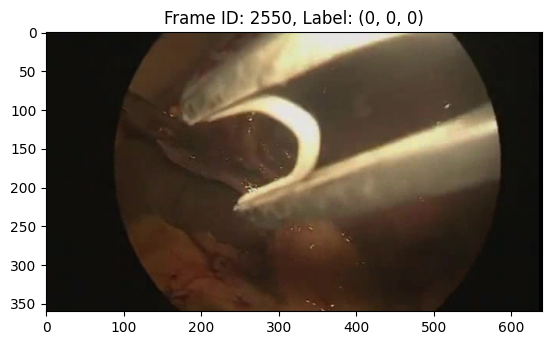

In [ ]:
for index, row in label.iterrows():
    frame_id = row['frame_id']
    c1,c2,c3 = row['c1_majority'],row['c2_majority'],row['c3_majority']
    frame_path = os.path.join(frames_path, video_name, f"{frame_id+1:04d}.jpg")  # Assuming frame files are in PNG format

    img = Image.open(frame_path)
    plt.imshow(img)
    plt.title(f"Frame ID: {frame_id}, Label: {c1,c2,c3}")
    plt.show()
    plt.pause(0.1)
    clear_output(wait=True)
    plt.close()

Video 0a251006-696c-48b2-b660-edeab505ef63, frame 0
Label of c1 c2 c3: tensor([0., 0., 0.])
Confidence aware labels: {'c1': 0.25, 'c2': 0.25, 'c3': 0.25}


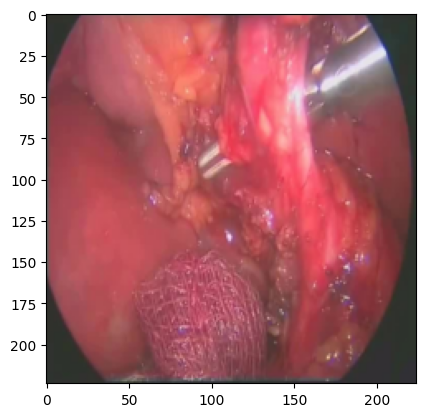

In [ ]:
import datasets
import datasets.cvs_datasets
from importlib import reload
reload(datasets)
reload(datasets.cvs_datasets)
from datasets.cvs_datasets import CVSData
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

frames_path = 'data/frames'
labels_path = 'data/labels'
dataset = CVSData(frames_path=frames_path, labels_path=labels_path, transform=transform)

img, label, video_name, frame_id, metadata = dataset[0]
print(f'Video {video_name}, frame {frame_id}')
print('Label of c1 c2 c3:', label)
print(f'Confidence aware labels: {metadata["confidence_aware_labels"]}')
image_width, image_height = img.shape[2], img.shape[1]

plt.imshow(img.permute(1,2,0))
plt.show()

# 2 - Building & Running Multi-class Models

In this section we demonstrate how to
1. Build a model for multi label classification task.
2. Perform a simple forward pass of a PyTorch batch input using a ViT based model.
3. Predict the class labels corresponding to the frames.

In the CVS Challenge there are **three binary labels** corresponding to the three CVS criteria C1, C2 and C3. For more information on the dataset & labels visit https://cvs-challenge.grand-challenge.org/dataset/.

In [ ]:
# Define a model for multi label classification.

class ViTMultiLabelClassifier(nn.Module):
    def __init__(self, num_classes=3, dropout=0.0, pretrained=True):
        super(ViTMultiLabelClassifier, self).__init__()
        # Pre-trained ViT as backbone
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.vit.head = nn.Identity()

        # MLP as classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes),
        )

    def forward(self, x:torch.Tensor)->torch.Tensor:
        """ Classify images
        Args:
          x (torch.Tensor): The input images, of size BxCxHxW.

        Returns:
          torch.Tensor: a Bx3 vector specifying the confidence for each label (C1,C2,C3 of the CVS)
        """
        x = self.vit(x)  # Pass input image to ViT
        x = self.classifier(x)  # Pass through MLP classifier
        return torch.sigmoid(x)  # Use sigmoid for multi-label classification

# Example of use of the class
if __name__ == "__main__":
    model = ViTMultiLabelClassifier()
    input_tensor = torch.rand((1, 3, 224, 224))

    outputs = model(input_tensor)
    print("Model outputs:", outputs)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model outputs: tensor([[0.4403, 0.4500, 0.4610]], grad_fn=<SigmoidBackward0>)


# 3 - Prediction of the CVS Criteria

In this section we create a dataloader and demonstrate the target format for challenge submissions, by running the model on the data examples, aggregating results over the dataset, and then saving the result.json file.

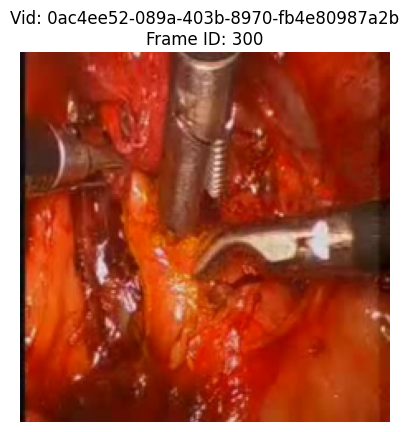

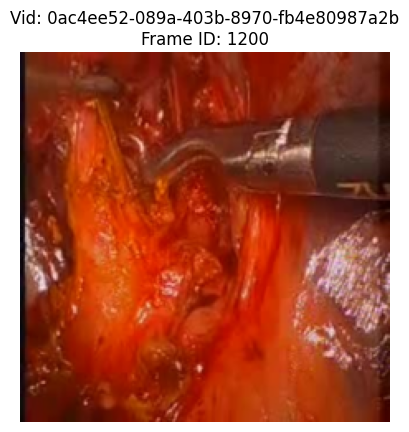

In [ ]:
from util.util import save_results,load_results

# Create dataset and dataloader.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

frames_path = 'data/frames'
labels_path = 'data/labels'

# This is a demo PyTorch dataset to be used within the challenge, loading the 3 sample videos provided for demo purposes.
dataset = CVSData(frames_path=frames_path, labels_path=labels_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Create model instance
model = ViTMultiLabelClassifier()

# Run the classifier model, estimate the label confidences over the whole dataset.
# Save the labels, confidences from both ground truth and model results.

overall_outputs=[]
overall_predictions=[]
overall_labels=[]
overall_confidence_aware_labels=[]
overall_raw_labels={
                    'c1':[],
                    'c2':[],
                    'c3':[]
                    }
for img, label, video_name, frame_id, metadata in dataloader:
    output = model(img)
    prediction = (output > 0.5).float()
    overall_labels.append(label.cpu().numpy())
    overall_confidence_aware_labels.append(np.transpose(np.array([metadata['confidence_aware_labels']['c1'],
                                            metadata['confidence_aware_labels']['c2'],
                                            metadata['confidence_aware_labels']['c3']])))
    for crit in ['c1','c2','c3']:
      overall_raw_labels[crit].append(np.concatenate(np.expand_dims(metadata['raw_labels'][crit],0),1))
    overall_predictions.append(prediction.detach().cpu().numpy())
    overall_outputs.append(output.detach().cpu().numpy())

# Plot over the last example
batch_size = img.shape[0]
for i in range(batch_size):
    plt.imshow(img[i].permute(1, 2, 0))
    # Convert from (C, H, W) to (H, W, C) for plotting
    plt.title(f"Vid: {video_name[i]}\nFrame ID: {frame_id[i]}")
    plt.axis('off')
    # Hide axes
    plt.show()

for crit in ['c1','c2','c3']:
    overall_raw_labels[crit]=np.transpose(np.concatenate(overall_raw_labels[crit],1))
overall_predictions=np.concatenate(overall_predictions)
# N_samples x 3, values are 0 or 1
overall_labels=np.concatenate(overall_labels)
# Ground truth values, N_samples x 3, values are 0 or 1
overall_outputs=np.concatenate(overall_outputs)
# N_samples x 3, values are continuous between 0 and 1
overall_confidence_aware_labels = np.concatenate(overall_confidence_aware_labels)

# Save results file. This file represents the format expected by the challenge for a given dataset, as the submission file.
save_results(overall_predictions,overall_outputs,'result.json')

dataset_results=load_results('result.json')

# 4 - Evaluation using CVS Challenge Metrics

In this section we demonstrate how to compute the CVS Challenge metrics. For more information please visit https://cvs-challenge.grand-challenge.org/evaluation1/  (Access only after successful challenge registration).


*   For **Subchallenge A**, we are looking for models with the highest Mean Average Precision (mAP) on CVS detection.
*   For **Subchallenge B**, we are looking for predictive models that demonstrate “awareness” of the inherent uncertainty represented in a given image,
both in terms of the subjectivity of the task (CVS classification) and complexity of the case being annotated.
We will calculate the uncertainty of the Brier Score (BS).
*   For **Subchallenge C**, we are looking for the model robustness to variations in distribution shifts. These can be linked to clinical characteristics or technical attributes of the data.

We will evaluate submissions on the held out 300 testing videos. For subchallenge C we will use several testing on variant datasets  (resamples from the 300 testing videos with undisclosed distribution shifts) to examine robustness to deployment-time distribution shifts. These shifts will be based on the demographic and clinical metadata (for more details visit https://cvs-challenge.grand-challenge.org/dataset/).

Performance will be calculated over all images in the dataset and then averaged across the CVS criteria for each of the variant test sets. We will pick the minimum average precisions across all these variant splits, ignoring the bottom 90th percentile to account for outliers.

In [ ]:
from util.metrics import compute_overall_metrics
'''
Evaluate metrics
'''

# Use the results from the saved json.
overall_predictions2 = dataset_results['estimated_detected_labels']
overall_outputs2 = dataset_results['estimated_label_confidences']

# Print the dataset/result items and their sizes
print(f'Prediction of c1 c2 c3: {overall_predictions}')
print(overall_raw_labels['c1'])
print(overall_confidence_aware_labels)
print(len(overall_raw_labels['c1']))
print(len(overall_predictions2[:,i]))

# Run metrics computation
metrics = compute_overall_metrics(overall_labels, overall_confidence_aware_labels, overall_outputs2)

# Extract the metrics from the result of the metrics computation
accuracy = metrics['accuracy']
f1 = metrics['f1']
mAP = metrics['mAP']

# Print the results of the metrics computation
print(f'Label of c1 c2 c3: {overall_labels}')
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"mAP Score: {mAP}")

for i,key in enumerate(['c1','c2','c3']):
  brier_score = metrics['brier_score'][key]
  print(f"Brier score for c{i}: {brier_score}")





Prediction of c1 c2 c3: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 1.]
 [0. 0. 1.]]
[[0 0 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 1]
 [0 0 1]
 [0 1 1]
 [0 0 1]
 [0 0 0]
 [0 1 1]
 [0 0 0]
 [0 0 0]
 [1 1 1]
 [0 1 1]
 [0 0 0]
 [0 1 1]
 [0 0 1]
 [0 1 1]
 [0 1 1]
 [0 0 0]
 [0 1 1]
 [0 0 1]
 [0 1 1]
 [0 0 1]
 [0 0 0]
 [0 1 1]
 [0 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0

In [ ]:
print(metadata)
print(frame_id)
print(np.concatenate(np.expand_dims(metadata['raw_labels']['c1'],0),1))

{'raw_labels': {'c1': [tensor([0, 0]), tensor([0, 0]), tensor([0, 0])], 'c2': [tensor([0, 0]), tensor([0, 0]), tensor([0, 0])], 'c3': [tensor([0, 0]), tensor([0, 0]), tensor([0, 0])]}, 'confidence_aware_labels': {'c1': tensor([0.1667, 0.1667], dtype=torch.float64), 'c2': tensor([0.1667, 0.1667], dtype=torch.float64), 'c3': tensor([0.1667, 0.1667], dtype=torch.float64)}}
tensor([ 300, 1200])
[[0 0]
 [0 0]
 [0 0]]
